In [1]:
import os
import glob
import json
import torch
import argparse
import utils_plot
import numpy as np
from torch import nn
from tqdm import tqdm
from pathlib import Path
from models import UNet11
from loss import dice_coef
import torch.backends.cudnn
import torch.optim as optim
from torch.optim import Adam
import albumentations as albu
import matplotlib.pyplot as plt
from dataset import WaterDataset
from scalarmeanstd import meanstd
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler 
from torch.utils.data import DataLoader
from metrics_prediction import calc_loss
from split_train_val import get_files_names
from torchvision import transforms, datasets, models
from get_train_test_kfold import get_split_out, percent_split, get_split_in

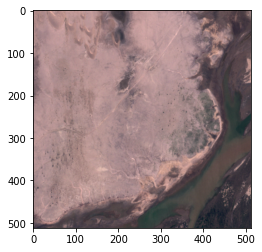

In [2]:
img = np.load(os.path.join('data/','train_val_850_2/images/rgbnir24608-3072.npy'))[:3]
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img.transpose(1,2,0))

## Definitions

In [3]:
num_classes = 1
input_channels = 4
batch_size = 4
lr = 0.005

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


cuda:1


In [5]:
#Definition of teacher model
model_teach = UNet11(num_classes=num_classes, input_channels=input_channels)

In [6]:
if torch.cuda.is_available():
    model_teach = nn.DataParallel(model_teach, device_ids=[1])

In [7]:
data_path = Path("data/")


#Labeled images
train_val_file_names = np.array(sorted(glob.glob(str((data_path/'train_val_850_2'/'images'))+ "/*.npy")))
test_file_names = np.array(sorted(glob.glob(str((data_path/'test_850_2'/'images')) + "/*.npy")))

train_file_lab,val_file_lab = get_split_in(train_val_file_names,0)

max_values, mean_values, std_values=meanstd(train_file_lab, val_file_lab,test_file_names,str(data_path),input_channels)

print(mean_values, std_values, max_values)

elapsed time: 6.448278532829136
Train: data 751 min  0 max  3521
mean:[0.11289885 0.10246669 0.11346575 0.1396483 ]
std:[0.08914584 0.0666959  0.05693271 0.11042776]
Val: data 188 min  0 max  3440
mean:[0.11717311 0.10560063 0.1165011  0.13805926]
std:[0.09240376 0.06936888 0.05979758 0.11221593]
Test: data 182 -min  0 max  3272
mean:[0.10808238 0.09674959 0.10814647 0.13168366]
std:[0.08546968 0.06265724 0.05298235 0.10878518]
All: data 945 min  0 max  3521
mean:[0.11383374 0.10310764 0.11405758 0.13963067]
std:[0.08972336 0.06713878 0.05742005 0.11076992]
[0.11289885 0.10246669 0.11346575 0.1396483 ] [0.08914584 0.0666959  0.05693271 0.11042776] 3521


In [8]:
def make_loader(file_names, shuffle=False, transform=None, limit=None,  mode = "train",batch_size=4,limite=None) :
    return DataLoader(
        dataset=WaterDataset(file_names, transform=transform, mode = mode,limit=limit),
        shuffle=shuffle,
        batch_size= batch_size,
        pin_memory=False
    )

## Transformations

In [9]:
train_transforms = albu.Compose([
    albu.Normalize(mean=mean_values, std=std_values, max_pixel_value=max_values)
])

val_transforms = albu.Compose([
    albu.CenterCrop(height=512,width=512),
    albu.Normalize(mean=mean_values, std=std_values, max_pixel_value=max_values)
])

In [10]:
train_loader_lab = make_loader(train_file_lab, shuffle=True, transform=train_transforms , batch_size = batch_size , mode = "train")
valid_loader_lab = make_loader(val_file_lab, transform=val_transforms, batch_size = batch_size, mode = "train")

In [11]:
dataloaders_lab= {
    'train': train_loader_lab, 'val': valid_loader_lab
}

In [12]:
dataloaders_sizes = {
    x: len(dataloaders_lab[x]) for x in dataloaders_lab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 188, 'val': 47}


## Printing some images and labels

Training images (only RGB)


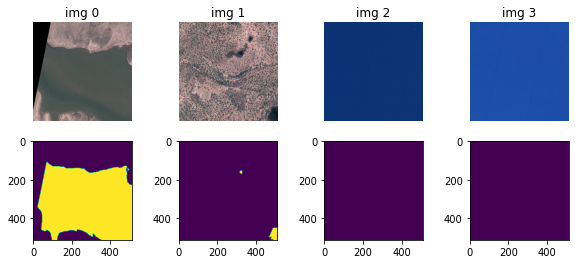

In [13]:
print('Training images (only RGB)')
images, labels = next(iter(train_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    ax.imshow(labels[ii].squeeze().numpy())

Validation images (only RGB)


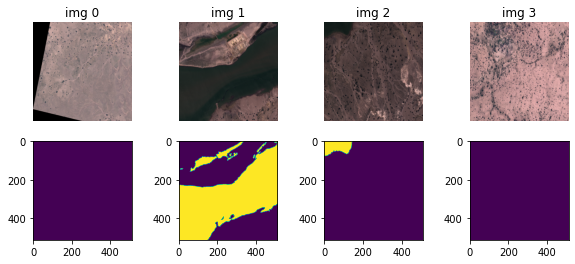

In [14]:
print('Validation images (only RGB)')
images, labels = next(iter(valid_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)

In [15]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

## Training the Teacher Model

In [16]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 30
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [17]:
#Initializing model weights, loss and output file
import copy
import time
from collections import defaultdict
best_model_teach_wts = copy.deepcopy(model_teach.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [18]:
phase_loss_list = {
    'train':[], 'val':[]
}

for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_teach.train()  # Set model to training mode
        else:
            model_teach.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_lab, labels_lab= next(iter(dataloaders_lab[phase]))    

            input_lab = input_lab.to(device)
            labels_lab = labels_lab.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_lab = model_teach(input_lab)
                loss = calc_loss(pred_lab, labels_lab, metrics)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples_loss += input_lab.size(0)
            epoch_samples_l2 += input_lab.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        
        print('{} loss {:.3f}'.format(phase, epoch_loss))
        phase_loss_list[phase].append(epoch_loss)
        
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_teach_wts = copy.deepcopy(model_teach.state_dict())


    time_elapsed = time.time() - since
    print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

------------------------ EPOCH 0 ------------------------
LR 0.005


/home/agallardo/ternaus/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss 5788.387
val loss 1.923
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 1 ------------------------
LR 0.005
train loss 0.908
val loss 0.800
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 2 ------------------------
LR 0.005
train loss 0.707
val loss 0.818
Time elapsed: 0m 9s
------------------------ EPOCH 3 ------------------------
LR 0.005
train loss 0.534
val loss 0.410
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 4 ------------------------
LR 0.005
train loss 0.476
val loss 0.392
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 5 ------------------------
LR 0.005
train loss 0.531
val loss 0.382
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 6 ------------------------
LR 0.005
train loss 0.450
val loss 0.369
Saving best model...
Time elapsed: 0m 9s
------------------------ EPOCH 7 ------------------------
LR 0.005
train loss 0.433
val loss 0.343
Saving

In [19]:
model_teach.load_state_dict(best_model_teach_wts)

<All keys matched successfully>

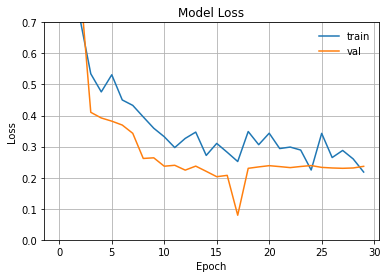

In [20]:
plt.plot(phase_loss_list['train'],label='train')
plt.plot(phase_loss_list['val'], label='val')
plt.legend(frameon=False)
plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title("Model Loss")
plt.show()

# Generating labels for unlabeled dataset

In [21]:
#Unlabeled images

train_val_file_names_unlab = np.array(sorted(glob.glob(str((data_path/'unlabel'/'sftr'/'images'))+ "/*.npy")))
train_file_unlab,val_file_unlab = get_split_in(train_val_file_names_unlab,0)

In [22]:
#Train and validation loaders
train_loader_unlab = make_loader(train_file_unlab, shuffle=True, transform=train_transforms, batch_size = batch_size//2, mode = "unlb_train")
valid_loader_unlab = make_loader(val_file_unlab, transform=val_transforms, batch_size = batch_size//2, mode = "unlb_val")

In [23]:
dataloaders_unlab= {
    'train': train_loader_unlab, 'val': valid_loader_unlab
}

In [24]:
dataloaders_sizes = {
    x: len(dataloaders_unlab[x]) for x in dataloaders_unlab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 122, 'val': 31}


In [25]:
print('Generating masks from loaders...')
for loader in [train_loader_unlab, valid_loader_unlab]:
    for images, labels in iter(loader):
        for ii in range(len(images)):
            label = model_teach(images[ii].unsqueeze(0))
            label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
            mask = label[:,:] >= label.mean()

            img_name = labels[ii]
            pos = img_name.find("images")
            mask_name = img_name[:pos] + 'masks/' + img_name[pos+7:-4] + "_a.npy"
            mask = np.expand_dims(mask, axis=0)
            np.save(mask_name, mask)
print("Masks generated!")

Generating masks from loaders...
Masks generated!


## Preparing dataset for student model

In [26]:
#Train and validation loaders, now in train mode since we have labels
train_loader_pseudo = make_loader(np.array(list(train_file_unlab) + list(train_file_lab)), shuffle=True, transform=train_transforms, batch_size = batch_size//2, mode = "train")
valid_loader_pseudo = make_loader(np.array(list(val_file_unlab) + list(val_file_lab)), transform=val_transforms, batch_size = batch_size//2, mode = "train")

In [27]:
dataloaders_pseudo= {
    'train': train_loader_pseudo, 'val': valid_loader_pseudo
}

In [28]:
dataloaders_sizes = {
    x: len(dataloaders_pseudo[x]) for x in dataloaders_pseudo.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 498, 'val': 125}


Images with pseudolabels (only RGB)


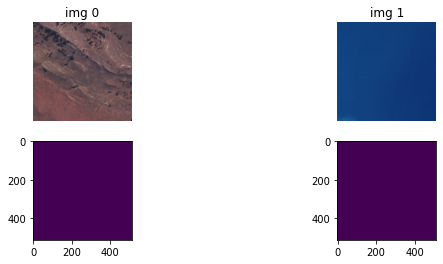

In [29]:
print('Images with pseudolabels (only RGB)')
images, labels = next(iter(train_loader_pseudo))

fig, axes = plt.subplots(figsize=(10,4), ncols=2, nrows=2)
for ii in range(2):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)

## Training student model

In [31]:
#Definition of the student model
model_stud = UNet11(num_classes=num_classes, input_channels=input_channels)

if torch.cuda.is_available():
    model_stud = nn.DataParallel(model_stud, device_ids=[1])
    
model_stud.load_state_dict(torch.load("models/model_30epoch_UNet11_fold0.pth"))

<All keys matched successfully>

In [32]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

In [33]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 30
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [34]:
best_model_stud_wts = copy.deepcopy(model_stud.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [35]:
for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_stud.train()  # Set model to training mode
        else:
            model_stud.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_pseudo, labels_pseudo= next(iter(dataloaders_pseudo[phase]))    

            input_pseudo = input_pseudo.to(device)
            labels_pseudo = labels_pseudo.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_pseudo = model_stud(input_pseudo)
                loss = calc_loss(pred_pseudo, labels_pseudo, metrics)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples_loss += input_pseudo.size(0)
            epoch_samples_l2 += input_pseudo.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        print('{} loss {:.3f}'.format(phase, epoch_loss))
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_stud_wts = copy.deepcopy(model_stud.state_dict())


    time_elapsed = time.time() - since

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

------------------------ EPOCH 0 ------------------------
LR 0.005
train loss 0.706
val loss 0.856
Saving best model...
------------------------ EPOCH 1 ------------------------
LR 0.005
train loss 0.709
val loss 0.856
------------------------ EPOCH 2 ------------------------
LR 0.005
train loss 0.720
val loss 0.856
------------------------ EPOCH 3 ------------------------
LR 0.005
train loss 0.733
val loss 0.856
------------------------ EPOCH 4 ------------------------
LR 0.005
train loss 0.700
val loss 0.856
------------------------ EPOCH 5 ------------------------
LR 0.005
train loss 0.762
val loss 0.856
------------------------ EPOCH 6 ------------------------
LR 0.005
train loss 0.760
val loss 0.856
------------------------ EPOCH 7 ------------------------
LR 0.005
train loss 0.681
val loss 0.856
------------------------ EPOCH 8 ------------------------
LR 0.005
train loss 0.754
val loss 0.856
------------------------ EPOCH 9 ------------------------
LR 0.005
train loss 0.715
val 

In [36]:
torch.save(model_stud.state_dict(), "models/model_{}epoch_{}_fold{}.pth".format(num_epochs, "UNet11", "0"))

## Testing the student model

In [37]:
model_stud.load_state_dict(torch.load("models/model_30epoch_UNet11_fold0.pth"))

<All keys matched successfully>

In [38]:
test_loader = make_loader(test_file_names, transform=val_transforms)

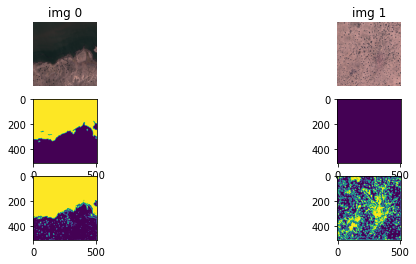

In [40]:
images, labels = next(iter(test_loader))

fig, axes = plt.subplots(figsize=(10,4), ncols=2, nrows=3)
for ii in range(2):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)
    
    ax = axes[2][ii]
    label = model_stud(images[ii].unsqueeze(0))
    label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
    mask = label[:,:] < label.mean()
    ax.imshow(mask)

In [41]:
dice_results = []

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        pred = torch.sigmoid(model_stud(data))
        dice = dice_coef(pred.cpu(), target.cpu())
        
        dice_results += [dice.data.cpu().numpy()]
    
print("Testing Statistics")
print("Test Dice = ", np.mean(dice_results))

100%|██████████| 46/46 [00:07<00:00,  6.34it/s]

Testing Statistics
Test Dice =  0.3341053
